In [ ]:
# !pip install pretrainedmodels==0.7.4
# !pip install efficientnet-pytorch==0.6.3
# !pip install timm==0.3.2

In [ ]:
# # 1.4.0 버전
# !pip install torch==1.4.0
# !pip install torchvision==0.5.0

In [ ]:
# # 1.6.0 버전
# !pip install torch==1.6.0
# !pip install torchvision==0.7.0

In [1]:
!nvidia-smi

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import SimpleITK as sitk
import cv2
from tqdm import tqdm

import sys
sys.path.append(os.path.abspath('/workspace/sunggu'))
sys.path.append(os.path.abspath('/workspace/sunggu/4.Dose_img2img'))
sys.path.append(os.path.abspath('/workspace/sunggu/MONAI'))
from sunggu_utils import check_value, take_list, plot_confusion_matrix, list_sort_nicely, find_dir, plot_3D

Thu Apr  1 01:44:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.39       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:1B:00.0 Off |                  N/A |
|100%   88C    P2   169W / 280W |  14728MiB / 24220MiB |     83%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:1C:00.0 Off |                  N/A |
| 47%   

In [2]:
torch.__version__

'1.6.0'

## Setup imports

In [3]:
import glob
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import skimage
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.losses import DiceLoss, GeneralizedDiceLoss, FocalLoss, TverskyLoss
from monai.metrics import compute_meandice, DiceMetric, ConfusionMatrixMetric 
from monai.networks.layers import Norm
from monai.networks.nets import UNet, highresnet
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadNiftid,
    LoadNumpyd,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    Lambdad,
    ToTensord,
    RandScaleIntensityd,
    RandGaussianNoised,
    RandFlipd,
    RandZoomd,
    RandGaussianNoised,
    RandGaussianSmoothd,
    RandShiftIntensityd,
    SpatialPadd,
    RandAffined,
    CastToTyped,
    DeleteItemsd,
    FgBgToIndicesd,
    Rand3DElasticd,
    RandZoomd,
    Rand2DElasticd,
    RandWeightedCropd,
    AsDiscrete,
    SpatialPadd,
    CenterSpatialCropd,
    adaptor,
)
from monai.utils import first, set_determinism

print_config()

MONAI version: 0+unknown
Python version: 3.6.9 (default, Jul 17 2020, 12:50:27)  [GCC 8.4.0]
OS version: Linux (4.15.0-137-generic)
Numpy version: 1.18.5
Pytorch version: 1.6.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.0
scikit-image version: 0.17.2
Pillow version: 8.0.1
Tensorboard version: 2.3.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.7.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.50.2

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Set 시드

In [4]:
import random

random_seed = 7
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

set_determinism(seed=7)

## Set Train / Test

In [5]:
train_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise20_b50f_5.0/*/*.npy'))
train_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/*/*.npy'))

valid_low_images  = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise20_b50f_5.0/*/*.npy'))
valid_high_images = list_sort_nicely(glob.glob('/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Valid/noise100_b50f_5.0/*/*.npy'))

total_low_list  = train_low_images  + valid_low_images
total_high_list = train_high_images + valid_high_images

train_files = [{"low": low_name, "high": high_name} for low_name, high_name in zip(total_low_list, total_high_list)]

## Augmentation

In [6]:
# CT에 맞는 Augmentation
from torchvision import transforms
train_transforms = Compose(
    [
        LoadNumpyd(keys=["low", "high"]),
        AddChanneld(keys=["low", "high"]), 
        ToTensord(keys=["low", "high"]),
        Lambdad(keys=["low", "high"], func=transforms.Normalize(mean=(0.5), std=(0.5))),
    ]
)

## Check transforms in DataLoader

In [7]:
def visual_windowing(x):
    x = (x * 0.5) + 0.5 
    x = np.clip(x, a_min=0.250, a_max=0.270)
    x -= x.min()
    x /= x.max()  
    
    return x

/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise20_b50f_5.0/HUH_JEO_F79/HUH_JEO_F79_001_20210218_184354_00026.npy
/workspace/sunggu/4.Dose_img2img/dataset/sinogram_dataset/2D_dataset/Train/noise100_b50f_5.0/HUH_JEO_F79/HUH_JEO_F79_001_20210218_184251_00026.npy
image shape: torch.Size([512, 512])


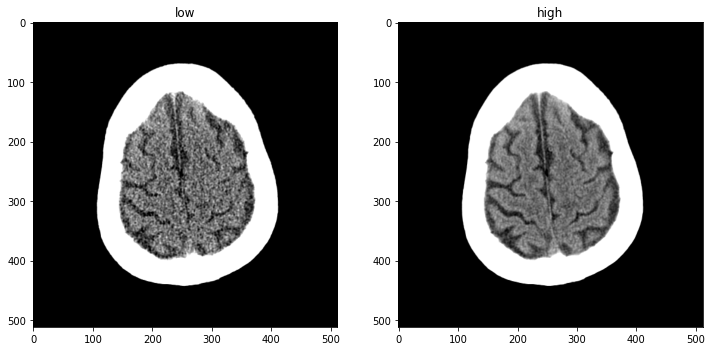

In [8]:
check_ds = Dataset(data=train_files, transform=train_transforms)
# check_loader = DataLoader(check_ds, batch_size=1, shuffle=False)
# check_data = next(iter(check_loader))

check_data = check_ds[160]

print(check_data['low_meta_dict']['filename_or_obj'])
print(check_data['high_meta_dict']['filename_or_obj'])

low = (check_data["low"][0])
high = (check_data["high"][0])
print(f"image shape: {low.shape}")

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("low")
plt.imshow(visual_windowing(low), cmap="gray")

plt.subplot(1, 2, 2)
plt.title("high")
plt.imshow(visual_windowing(high), cmap="gray")

plt.show()

In [9]:
import multiprocessing
# from torchsampler.imbalanced import ImbalancedDatasetSampler, sunggu_ImbalancedDatasetSampler

# cf) use batch_size=2 to load images and use RandCropByPosNegLabeld
print("CPU 갯수 = ", multiprocessing.cpu_count())

# Cachedataset 이거 뭔가 문제가 있음...
train_ds = Dataset(data=train_files, transform=train_transforms)
# train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=0.5)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=8, drop_last=True)

CPU 갯수 =  32


## Create Model, Loss, Optimizer

In [10]:
def init_net_multi_gpu(net, init_type='normal', init_gain=0.02):
    net = torch.nn.DataParallel(net)
    net.to('cuda')        
    init_weights(net, init_type, init_gain=init_gain)
    return net

def init_net_sigle_gpu(net, init_type='normal', init_gain=0.02):
    net.to('cuda')        
    init_weights(net, init_type, init_gain=init_gain)
    return net

In [11]:
from OT_CycleGAN_sunggu.models import *
from Cyclegan_sunggu.util import *
import itertools

device = 'cuda'

# 모델
netG_low_2_high = OT_Generator(in_channels=1, out_channels=1, feature=64)
netG_high_2_low = OT_Generator(in_channels=1, out_channels=1, feature=64)

netD_low  = OT_Discriminator(in_channels=1, out_channels=1, feature=64)
netD_high = OT_Discriminator(in_channels=1, out_channels=1, feature=64)

# multi-gpu 사용
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    
    netG_low_2_high = init_net_multi_gpu(netG_low_2_high, init_type='normal', init_gain=0.02)
    netG_high_2_low = init_net_multi_gpu(netG_high_2_low, init_type='normal', init_gain=0.02)

    netD_low        = init_net_multi_gpu(netD_low, init_type='normal', init_gain=0.02)
    netD_high       = init_net_multi_gpu(netD_high, init_type='normal', init_gain=0.02)

else :
    netG_low_2_high = init_net_sigle_gpu(netG_low_2_high, init_type='normal', init_gain=0.02)
    netG_high_2_low = init_net_sigle_gpu(netG_high_2_low, init_type='normal', init_gain=0.02)

    netD_low        = init_net_sigle_gpu(netD_low, init_type='normal', init_gain=0.02)
    netD_high       = init_net_sigle_gpu(netD_high, init_type='normal', init_gain=0.02)

    

initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal


In [ ]:
# from torchsummary import summary
# input_size = (1,32,320,320)
# summary(model.encoder, input_size, batch_size=-1, device='cpu')

## 모델 이어서 학습하기

In [12]:
## 네트워크 불러오기
checkpoint_dir = '/workspace/sunggu/4.Dose_img2img/model/OT_Cycle_Gan_2D_sinogram_fullbatch/epoch_60_model.pth'
checkpoint = torch.load(checkpoint_dir)

epoch = checkpoint['epoch']

netG_low_2_high.load_state_dict(checkpoint['netG_low_2_high_state_dict'])
netG_high_2_low.load_state_dict(checkpoint['netG_high_2_low_state_dict'])
netD_low.load_state_dict(checkpoint['netD_low_state_dict'])
netD_high.load_state_dict(checkpoint['netD_high_state_dict'])
     

## multi-gpu 사용
if torch.cuda.device_count() > 1:
    netG_low_2_high = torch.nn.DataParallel(netG_low_2_high)
    netG_high_2_low = torch.nn.DataParallel(netG_high_2_low)
    netD_low = torch.nn.DataParallel(netD_low)
    netD_high = torch.nn.DataParallel(netD_high)
    
    
netG_low_2_high.to('cuda')  
netG_high_2_low.to('cuda')  
netD_low.to('cuda')  
netD_high.to('cuda')  


OT_Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (leaky1): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance2): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (leaky2): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (instance3): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (leaky3): LeakyReLU(negative_slope=0.2, inplace=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (instance4): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (leaky4): LeakyReLU(negative_slope=0.2, inplace=True)
  (last): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (output): Sigmoid()
)

## 손실함수 정의하기

In [13]:
cycle_loss = nn.L1Loss()
# gan_loss = nn.BCELoss()
identity_loss = nn.L1Loss()

learning_rate = 2e-4
max_epochs = 1000

# Optimizer 설정하기
optimizer_G = torch.optim.Adam(itertools.chain(netG_low_2_high.parameters(), netG_high_2_low.parameters()), lr=learning_rate, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(netD_low.parameters(), netD_high.parameters()), lr=learning_rate, betas=(0.5, 0.999))

def lambda_rule(epoch, start_decay_epoch=100, total_epoch=1000):
    lr = 1.0 - max(0, epoch - start_decay_epoch) / float(total_epoch)
    return lr

scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda_rule)
scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=lambda_rule)

# Generated image pool
from Cyclegan_sunggu.image_pool import ImagePool
num_pool = 0
fake_low_pool  = ImagePool(num_pool)
fake_high_pool = ImagePool(num_pool)

In [14]:
optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])

scheduler_G.load_state_dict(checkpoint['scheduler_G'])        
scheduler_D.load_state_dict(checkpoint['scheduler_D'])      

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:218: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


###### 필요한 Weight만 Load

In [ ]:
# # Before
# model_dict = model.state_dict()
# print("이전 weight = ", model_dict['encoder._conv_stem.weight'][0])

# load_dir = '/workspace/sunggu/1.Hemorrhage/monai_experiment/model/Efficient3d_conv2d_Aux/'
# pretrained_dict =  torch.load(os.path.join(load_dir, "epoch_0_best_metric_model.pth")) 

# # 1. filter out unnecessary keys
# pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
# # 2. overwrite entries in the existing state dict
# model_dict.update(pretrained_dict) 
# # 3. load the new state dict
# model.load_state_dict(model_dict)

# # After
# print("이후 weight = ", model_dict['encoder._conv_stem.weight'][0])

## Train

In [15]:
## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.cpu().detach().numpy().transpose(0, 2, 3, 1)
fn_denorm  = lambda x: (x * 0.5) + 0.5
fn_denorm_window  = visual_windowing

In [16]:
def grad_penalty(critic, real_data, fake_data, device='cuda'):
    
    alpha = torch.rand_like(real_data).to(device)

    interpolates = alpha*real_data + (1-alpha)*fake_data.detach()
    interpolates = interpolates.to(device)
    interpolates = torch.autograd.Variable(interpolates, requires_grad = True)

    critic_interpolates = critic(interpolates)

    gradients = torch.autograd.grad(outputs=critic_interpolates, 
                                    inputs=interpolates,
                                    grad_outputs=torch.ones(critic_interpolates.size()).to(device),
                                    create_graph=True, 
                                    retain_graph=True, 
                                    only_inputs=True)[0]

    gradients = gradients.view(gradients.size(0), -1)
    # Regularization hyperparameter for gradient penalty = 0.5, 공식 wgan-gp:10
    gradient_penalty = 0.5 * ((gradients.norm(2, dim=1) - 1) ** 2).mean() 

    return gradient_penalty

In [17]:
print(checkpoint['epoch'])

60


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
st_epoch = 0
num_D_iter = 5
epoch_num = 1000
val_interval = 10

epoch_train_loss_list = list()
epoch_val_loss_list = list()

epoch_train_metric_list = list()
epoch_val_metric_list = list()

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/OT_Cycle_Gan_2D_sinogram_fullbatch')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/OT_Cycle_Gan_2D_sinogram_fullbatch/'

low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/Train/png/'+'OT_Cycle_Gan_2D_sinogram_fullbatch'+'/low2high/'


# 모델 save폴더 만들기
if not os.path.exists(root_dir):
    os.makedirs(root_dir, mode=0o777)

if not os.path.exists(low2high_png_dir):
    os.makedirs(low2high_png_dir, mode=0o777)

    
for epoch in range(61, epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    netG_low_2_high.train()
    netG_high_2_low.train()
    netD_low.train()
    netD_high.train()
    
    # Loss 선언
    loss_G_low2high_train = []
    loss_G_high2low_train = []
    
    loss_D_low_train = []
    loss_D_high_train = []
    
    loss_cycle_low_train = []
    loss_cycle_high_train = []
    
    loss_ident_low_train = []
    loss_ident_high_train = []
        
    D_iterator = tqdm(train_loader, desc='D_Iteration', file=sys.stdout)  
    for batch_data in D_iterator:
        # Backward Discriminator  ################################################################        

        set_requires_grad([netD_low, netD_high], True)
        optimizer_D.zero_grad()

        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)

        output_low  = netG_high_2_low(input_high)
        output_high = netG_low_2_high(input_low)
     
            # LOW (Discriminator Gan Loss)
        pred_real_low = netD_low(input_low)        
        ### POOL
        output_low    = fake_low_pool.query(output_low)
        pred_fake_low = netD_low(output_low.detach())

        loss_D_low_real = -pred_real_low.mean()
        loss_D_low_fake = pred_fake_low.mean()
        loss_D_low = loss_D_low_real + loss_D_low_fake + grad_penalty(netD_low, input_low, output_low)

            # HIGH (Discriminator Gan Loss)
        pred_real_high = netD_high(input_high)
        ### POOL
        output_high    = fake_high_pool.query(output_high)
        pred_fake_high = netD_high(output_high.detach())

        loss_D_high_real = -pred_real_high.mean()
        loss_D_high_fake = pred_fake_low.mean()
        loss_D_high = loss_D_high_real + loss_D_high_fake + grad_penalty(netD_high, input_high, output_high)

        loss_D = loss_D_high + loss_D_low
        loss_D.backward()
        optimizer_D.step()

        # 기록
        loss_D_low_train  += [loss_D_low.item()]
        loss_D_high_train += [loss_D_high.item()]

    G_iterator = tqdm(train_loader, desc='G_Iteration', file=sys.stdout)  
    for batch_data in G_iterator:
        # Backward Generator ################################################################
        set_requires_grad([netD_low, netD_high], False)
        optimizer_G.zero_grad()

        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)        

        output_low  = netG_high_2_low(input_high)
        output_high = netG_low_2_high(input_low)
        
        recon_high  = netG_low_2_high(output_low)
        recon_low   = netG_high_2_low(output_high)           
        
        ident_low   = netG_high_2_low(input_low)
        ident_high  = netG_low_2_high(input_high)             
        
            # Gerator Gan Loss
        pred_fake_low  = netD_low(output_low)
        pred_fake_high = netD_high(output_high)

            # Gan loss
        loss_G_low2high = -pred_fake_low.mean()
        loss_G_high2low = -pred_fake_high.mean()

            # Cycle Loss
        loss_cycle_low  = cycle_loss(input_low, recon_low)
        loss_cycle_high = cycle_loss(input_high, recon_high)

            # Identity Loss
        loss_ident_low  = identity_loss(input_low, ident_low)
        loss_ident_high = identity_loss(input_high, ident_high)        

        loss_G = (loss_G_low2high + loss_G_high2low) + \
                10.0 * (loss_cycle_low + loss_cycle_high) + \
                0.5 * (10.0 * loss_ident_low + 10.0 * loss_ident_high)

        loss_G.backward()
        optimizer_G.step()

        # 기록
        loss_G_low2high_train += [loss_G_low2high.item()]
        loss_G_high2low_train += [loss_G_high2low.item()]

        loss_cycle_low_train  += [loss_cycle_low.item()]
        loss_cycle_high_train += [loss_cycle_high.item()]

        loss_ident_low_train  += [loss_ident_low.item()]
        loss_ident_high_train += [loss_ident_high.item()]
        
        
    print( "Generator Loss       [Low to High] = %.4f" %np.mean(loss_G_low2high_train) ) 
    print( "Generator Loss       [High to Low] = %.4f" %np.mean(loss_G_high2low_train) )
    print( "Discriminator LOss   [Low]         = %.4f" %np.mean(loss_D_low_train) )
    print( "Discriminator Loss   [High]        = %.4f" %np.mean(loss_D_high_train) )

    print( "Cycle Loss           [Low]         = %.4f" %np.mean(loss_cycle_low_train) )
    print( "Cycle Loss           [High]        = %.4f" %np.mean(loss_cycle_high_train) )

    print( "Identity Loss        [Low]         = %.4f" %np.mean(loss_ident_low_train) )
    print( "Identity Loss        [High]        = %.4f" %np.mean(loss_ident_high_train) )

    total_loss = np.mean(loss_G_low2high_train) + np.mean(loss_G_high2low_train) +\
                 np.mean(loss_D_low_train)      + np.mean(loss_D_high_train)     +\
                 np.mean(loss_D_high_train)     + np.mean(loss_cycle_high_train) +\
                 np.mean(loss_ident_low_train)  + np.mean(loss_ident_high_train)

    print( "TOTAL Loss                         = %.4f" %total_loss )

    # Tensorboard 저장하기
    input_low   = fn_denorm_window(fn_tonumpy((input_low)))
    input_high  = fn_denorm_window(fn_tonumpy((input_high)))
    output_high = fn_denorm_window(fn_tonumpy((output_high)))

    input_low   = np.clip(input_low, a_min=0, a_max=1)
    input_high  = np.clip(input_high, a_min=0, a_max=1)
    output_high = np.clip(output_high, a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output_high[0].squeeze(), cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_high.png',  input_high[0].squeeze(),  cmap="gray")

            
    # Loss Write    
    writer.add_scalar('loss_G_low2high', np.mean(loss_G_low2high_train), epoch)
    writer.add_scalar('loss_G_high2low', np.mean(loss_G_high2low_train), epoch)

    writer.add_scalar('loss_D_low', np.mean(loss_D_low_train), epoch)
    writer.add_scalar('loss_D_high', np.mean(loss_D_high_train), epoch)

    writer.add_scalar('loss_cycle_low', np.mean(loss_cycle_low_train), epoch)
    writer.add_scalar('loss_cycle_high', np.mean(loss_cycle_high_train), epoch)

    writer.add_scalar('loss_ident_low', np.mean(loss_ident_low_train), epoch)
    writer.add_scalar('loss_ident_high', np.mean(loss_ident_high_train), epoch)
    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:

        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'netG_low_2_high_state_dict': netG_low_2_high.module.state_dict(), 
                          'netG_high_2_low_state_dict': netG_high_2_low.module.state_dict(), 
                          'netD_low_state_dict': netD_low.module.state_dict(), 
                          'netD_high_state_dict': netD_high.module.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),  
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'netG_low_2_high_state_dict': netG_low_2_high.state_dict(), 
                          'netG_high_2_low_state_dict': netG_high_2_low.state_dict(), 
                          'netD_low_state_dict': netD_low.state_dict(), 
                          'netD_high_state_dict': netD_high.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                         

            torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
    # Scheduler
    writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
    old_lr = optimizer_G.param_groups[0]['lr']
    lr = optimizer_G.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

    scheduler_G.step()    
    scheduler_D.step()    

writer.close()

----------
epoch 61/1000
G_Iteration: 100%|██████████| 1733/1733 [46:52<00:00,  1.62s/it]
Generator Loss       [Low to High] = -0.9966
Generator Loss       [High to Low] = -0.9833
Discriminator LOss   [Low]         = 0.1052
Discriminator Loss   [High]        = 0.0142
Cycle Loss           [Low]         = 0.0027
Cycle Loss           [High]        = 0.0027
Identity Loss        [Low]         = 0.0022
Identity Loss        [High]        = 0.0021
TOTAL Loss                         = -1.8392
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 62/1000
G_Iteration: 100%|██████████| 1733/1733 [46:23<00:00,  1.61s/it]
Generator Loss       [Low to High] = -0.9967
Generator Loss       [High to Low] = -0.9834
Discriminator LOss   [Low]         = 0.0749
Discriminator Loss   [High]        = 0.0139
Cycle Loss           [Low]         = 0.0027
Cycle Loss           [High]        = 0.0026
Identity Loss        [Low]         = 0.0022
Identity Loss        [High]        = 0.0021
TOTAL Loss              

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 66/1000
G_Iteration: 100%|██████████| 1733/1733 [41:21<00:00,  1.43s/it]
Generator Loss       [Low to High] = -0.9808
Generator Loss       [High to Low] = -0.9834
Discriminator LOss   [Low]         = 0.1444
Discriminator Loss   [High]        = -0.0007
Cycle Loss           [Low]         = 0.0026
Cycle Loss           [High]        = 0.0026
Identity Loss        [Low]         = 0.0022
Identity Loss        [High]        = 0.0021
TOTAL Loss                         = -1.8144
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 67/1000
G_Iteration: 100%|██████████| 1733/1733 [41:39<00:00,  1.44s/it]
Generator Loss       [Low to High] = -0.9778
Generator Loss       [High to Low] = -0.9834
Discriminator LOss   [Low]         = 0.0086
Discriminator Loss   [High]        = -0.0030
Cycle Loss           [Low]         = 0.0026
Cycle Loss           [High]        = 0.0026
Identity Loss        [Low]         = 0.0022
Identity Loss        [H

Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 80/1000
G_Iteration: 100%|██████████| 1733/1733 [41:03<00:00,  1.42s/it]
Generator Loss       [Low to High] = -0.9752
Generator Loss       [High to Low] = -0.9837
Discriminator LOss   [Low]         = 0.0040
Discriminator Loss   [High]        = -0.0094
Cycle Loss           [Low]         = 0.0024
Cycle Loss           [High]        = 0.0024
Identity Loss        [Low]         = 0.0020
Identity Loss        [High]        = 0.0019
TOTAL Loss                         = -1.9674
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 81/1000
G_Iteration: 100%|██████████| 1733/1733 [41:02<00:00,  1.42s/it]
Generator Loss       [Low to High] = -0.9769
Generator Loss       [High to Low] = -0.9837
Discriminator LOss   [Low]         = 0.0063
Discriminator Loss   [High]        = -0.0084
Cycle Loss           [Low]         = 0.0024
Cycle Loss           [High]        = 0.0023
Identity Loss        [Low]         = 0.0020
Identity Loss        [H

Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 94/1000
G_Iteration: 100%|██████████| 1733/1733 [45:10<00:00,  1.56s/it]
Generator Loss       [Low to High] = -0.9697
Generator Loss       [High to Low] = -0.9837
Discriminator LOss   [Low]         = 0.0018
Discriminator Loss   [High]        = -0.0133
Cycle Loss           [Low]         = 0.0023
Cycle Loss           [High]        = 0.0022
Identity Loss        [Low]         = 0.0019
Identity Loss        [High]        = 0.0017
TOTAL Loss                         = -1.9724
Learning Rate 0.0002000000 -> 0.0002000000
----------
epoch 95/1000
G_Iteration: 100%|██████████| 1733/1733 [44:56<00:00,  1.56s/it]
Generator Loss       [Low to High] = -0.9697
Generator Loss       [High to Low] = -0.9837
Discriminator LOss   [Low]         = 0.0037
Discriminator Loss   [High]        = -0.0139
Cycle Loss           [Low]         = 0.0023
Cycle Loss           [High]        = 0.0022
Identity Loss        [Low]         = 0.0019
Identity Loss        [H

Learning Rate 0.0001992000 -> 0.0001992000
----------
epoch 108/1000
G_Iteration: 100%|██████████| 1733/1733 [44:24<00:00,  1.54s/it]
Generator Loss       [Low to High] = -0.0493
Generator Loss       [High to Low] = -0.9837
Discriminator LOss   [Low]         = 0.0018
Discriminator Loss   [High]        = -0.9340
Cycle Loss           [Low]         = 0.0021
Cycle Loss           [High]        = 0.0021
Identity Loss        [Low]         = 0.0018
Identity Loss        [High]        = 0.0016
TOTAL Loss                         = -2.8937
Learning Rate 0.0001990000 -> 0.0001990000
----------
epoch 109/1000
G_Iteration: 100%|██████████| 1733/1733 [44:40<00:00,  1.55s/it]
Generator Loss       [Low to High] = -0.0490
Generator Loss       [High to Low] = -0.9837
Discriminator LOss   [Low]         = 0.0013
Discriminator Loss   [High]        = -0.9343
Cycle Loss           [Low]         = 0.0021
Cycle Loss           [High]        = 0.0020
Identity Loss        [Low]         = 0.0017
Identity Loss        

Learning Rate 0.0001964000 -> 0.0001964000
----------
epoch 122/1000
G_Iteration: 100%|██████████| 1733/1733 [43:59<00:00,  1.52s/it]
Generator Loss       [Low to High] = -0.0325
Generator Loss       [High to Low] = -0.9838
Discriminator LOss   [Low]         = 0.0002
Discriminator Loss   [High]        = -0.9512
Cycle Loss           [Low]         = 0.0020
Cycle Loss           [High]        = 0.0019
Identity Loss        [Low]         = 0.0017
Identity Loss        [High]        = 0.0015
TOTAL Loss                         = -2.9133
Learning Rate 0.0001962000 -> 0.0001962000
----------
epoch 123/1000
G_Iteration: 100%|██████████| 1733/1733 [44:02<00:00,  1.52s/it]
Generator Loss       [Low to High] = -0.0325
Generator Loss       [High to Low] = -0.9836
Discriminator LOss   [Low]         = 0.0002
Discriminator Loss   [High]        = -0.9192
Cycle Loss           [Low]         = 0.0020
Cycle Loss           [High]        = 0.0019
Identity Loss        [Low]         = 0.0017
Identity Loss        

Learning Rate 0.0001936000 -> 0.0001936000
----------
epoch 136/1000
G_Iteration: 100%|██████████| 1733/1733 [44:12<00:00,  1.53s/it]
Generator Loss       [Low to High] = -0.0326
Generator Loss       [High to Low] = -0.9835
Discriminator LOss   [Low]         = 0.0002
Discriminator Loss   [High]        = -0.9509
Cycle Loss           [Low]         = 0.0019
Cycle Loss           [High]        = 0.0018
Identity Loss        [Low]         = 0.0016
Identity Loss        [High]        = 0.0015
TOTAL Loss                         = -2.9127
Learning Rate 0.0001934000 -> 0.0001934000
----------
epoch 137/1000
G_Iteration: 100%|██████████| 1733/1733 [44:18<00:00,  1.53s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9832
Discriminator LOss   [Low]         = 0.0001
Discriminator Loss   [High]        = -0.9504
Cycle Loss           [Low]         = 0.0019
Cycle Loss           [High]        = 0.0018
Identity Loss        [Low]         = 0.0016
Identity Loss        

Learning Rate 0.0001908000 -> 0.0001908000
----------
epoch 150/1000
G_Iteration: 100%|██████████| 1733/1733 [43:50<00:00,  1.52s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9835
Discriminator LOss   [Low]         = 0.0004
Discriminator Loss   [High]        = -0.9511
Cycle Loss           [Low]         = 0.0018
Cycle Loss           [High]        = 0.0017
Identity Loss        [Low]         = 0.0015
Identity Loss        [High]        = 0.0014
TOTAL Loss                         = -2.9131
Learning Rate 0.0001906000 -> 0.0001906000
----------
epoch 151/1000
G_Iteration: 100%|██████████| 1733/1733 [44:42<00:00,  1.55s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9835
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9511
Cycle Loss           [Low]         = 0.0018
Cycle Loss           [High]        = 0.0017
Identity Loss        [Low]         = 0.0015
Identity Loss        

Learning Rate 0.0001880000 -> 0.0001880000
----------
epoch 164/1000
G_Iteration: 100%|██████████| 1733/1733 [44:50<00:00,  1.55s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0001
Discriminator Loss   [High]        = -0.9522
Cycle Loss           [Low]         = 0.0017
Cycle Loss           [High]        = 0.0016
Identity Loss        [Low]         = 0.0014
Identity Loss        [High]        = 0.0013
TOTAL Loss                         = -2.9318
Learning Rate 0.0001878000 -> 0.0001878000
----------
epoch 165/1000
G_Iteration: 100%|██████████| 1733/1733 [44:51<00:00,  1.55s/it]
Generator Loss       [Low to High] = -0.0326
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 2.3517
Discriminator Loss   [High]        = -0.9667
Cycle Loss           [Low]         = 0.0017
Cycle Loss           [High]        = 0.0016
Identity Loss        [Low]         = 0.0014
Identity Loss        

Learning Rate 0.0001852000 -> 0.0001852000
----------
epoch 178/1000
G_Iteration: 100%|██████████| 1733/1733 [45:06<00:00,  1.56s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0016
Cycle Loss           [High]        = 0.0016
Identity Loss        [Low]         = 0.0014
Identity Loss        [High]        = 0.0013
TOTAL Loss                         = -2.9615
Learning Rate 0.0001850000 -> 0.0001850000
----------
epoch 179/1000
G_Iteration: 100%|██████████| 1733/1733 [45:11<00:00,  1.56s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0016
Cycle Loss           [High]        = 0.0016
Identity Loss        [Low]         = 0.0013
Identity Loss        

Learning Rate 0.0001824000 -> 0.0001824000
----------
epoch 192/1000
G_Iteration: 100%|██████████| 1733/1733 [44:24<00:00,  1.54s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0016
Cycle Loss           [High]        = 0.0015
Identity Loss        [Low]         = 0.0013
Identity Loss        [High]        = 0.0012
TOTAL Loss                         = -2.9617
Learning Rate 0.0001822000 -> 0.0001822000
----------
epoch 193/1000
G_Iteration: 100%|██████████| 1733/1733 [44:34<00:00,  1.54s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0016
Cycle Loss           [High]        = 0.0015
Identity Loss        [Low]         = 0.0013
Identity Loss        

Learning Rate 0.0001796000 -> 0.0001796000
----------
epoch 206/1000
G_Iteration: 100%|██████████| 1733/1733 [46:29<00:00,  1.61s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0015
Cycle Loss           [High]        = 0.0014
Identity Loss        [Low]         = 0.0012
Identity Loss        [High]        = 0.0012
TOTAL Loss                         = -2.9620
Learning Rate 0.0001794000 -> 0.0001794000
----------
epoch 207/1000
G_Iteration: 100%|██████████| 1733/1733 [46:31<00:00,  1.61s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0015
Cycle Loss           [High]        = 0.0015
Identity Loss        [Low]         = 0.0013
Identity Loss        

Learning Rate 0.0001768000 -> 0.0001768000
----------
epoch 220/1000
G_Iteration: 100%|██████████| 1733/1733 [44:45<00:00,  1.55s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0001
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0014
Cycle Loss           [High]        = 0.0014
Identity Loss        [Low]         = 0.0012
Identity Loss        [High]        = 0.0011
TOTAL Loss                         = -2.9620
Learning Rate 0.0001766000 -> 0.0001766000
----------
epoch 221/1000
G_Iteration: 100%|██████████| 1733/1733 [44:55<00:00,  1.56s/it]
Generator Loss       [Low to High] = -0.0325
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0030
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0014
Cycle Loss           [High]        = 0.0014
Identity Loss        [Low]         = 0.0012
Identity Loss        

Learning Rate 0.0001740000 -> 0.0001740000
----------
epoch 234/1000
G_Iteration: 100%|██████████| 1733/1733 [44:00<00:00,  1.52s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0001
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0014
Cycle Loss           [High]        = 0.0014
Identity Loss        [Low]         = 0.0012
Identity Loss        [High]        = 0.0011
TOTAL Loss                         = -2.9622
Learning Rate 0.0001738000 -> 0.0001738000
----------
epoch 235/1000
G_Iteration: 100%|██████████| 1733/1733 [44:07<00:00,  1.53s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0014
Cycle Loss           [High]        = 0.0013
Identity Loss        [Low]         = 0.0012
Identity Loss        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


G_Iteration: 100%|██████████| 1733/1733 [44:33<00:00,  1.54s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0001
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0014
Cycle Loss           [High]        = 0.0013
Identity Loss        [Low]         = 0.0012
Identity Loss        [High]        = 0.0011
TOTAL Loss                         = -2.9621
Learning Rate 0.0001730000 -> 0.0001730000
----------
epoch 239/1000
G_Iteration: 100%|██████████| 1733/1733 [44:48<00:00,  1.55s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0001
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0014
Cycle Loss           [High]        = 0.0013
Identity Loss        [Low]         = 0.0012
Identity Loss        [High]        = 0.0011
TOTAL Loss                         = -2.9622
L

Learning Rate 0.0001704000 -> 0.0001704000
----------
epoch 252/1000
G_Iteration: 100%|██████████| 1733/1733 [44:12<00:00,  1.53s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0013
Cycle Loss           [High]        = 0.0013
Identity Loss        [Low]         = 0.0011
Identity Loss        [High]        = 0.0010
TOTAL Loss                         = -2.9624
Learning Rate 0.0001702000 -> 0.0001702000
----------
epoch 253/1000
G_Iteration: 100%|██████████| 1733/1733 [44:04<00:00,  1.53s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0001
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0014
Cycle Loss           [High]        = 0.0013
Identity Loss        [Low]         = 0.0011
Identity Loss        

Learning Rate 0.0001676000 -> 0.0001676000
----------
epoch 266/1000
G_Iteration: 100%|██████████| 1733/1733 [44:04<00:00,  1.53s/it]
Generator Loss       [Low to High] = -0.0324
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9670
Cycle Loss           [Low]         = 0.0013
Cycle Loss           [High]        = 0.0012
Identity Loss        [Low]         = 0.0011
Identity Loss        [High]        = 0.0010
TOTAL Loss                         = -2.9625
Learning Rate 0.0001674000 -> 0.0001674000
----------
epoch 267/1000
G_Iteration: 100%|██████████| 1733/1733 [43:51<00:00,  1.52s/it]
Generator Loss       [Low to High] = -0.0162
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0094
Discriminator Loss   [High]        = -0.9769
Cycle Loss           [Low]         = 0.0013
Cycle Loss           [High]        = 0.0012
Identity Loss        [Low]         = 0.0011
Identity Loss        

Learning Rate 0.0001648000 -> 0.0001648000
----------
epoch 280/1000
G_Iteration: 100%|██████████| 1733/1733 [40:19<00:00,  1.40s/it]
Generator Loss       [Low to High] = -0.0162
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9832
Cycle Loss           [Low]         = 0.0013
Cycle Loss           [High]        = 0.0012
Identity Loss        [Low]         = 0.0011
Identity Loss        [High]        = 0.0010
TOTAL Loss                         = -2.9787
Learning Rate 0.0001646000 -> 0.0001646000
----------
epoch 281/1000
G_Iteration: 100%|██████████| 1733/1733 [40:21<00:00,  1.40s/it]
Generator Loss       [Low to High] = -0.0163
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9832
Cycle Loss           [Low]         = 0.0013
Cycle Loss           [High]        = 0.0012
Identity Loss        [Low]         = 0.0010
Identity Loss        

Learning Rate 0.0001620000 -> 0.0001620000
----------
epoch 294/1000
G_Iteration: 100%|██████████| 1733/1733 [40:16<00:00,  1.39s/it]
Generator Loss       [Low to High] = -0.0162
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9832
Cycle Loss           [Low]         = 0.0012
Cycle Loss           [High]        = 0.0012
Identity Loss        [Low]         = 0.0010
Identity Loss        [High]        = 0.0009
TOTAL Loss                         = -2.9788
Learning Rate 0.0001618000 -> 0.0001618000
----------
epoch 295/1000
G_Iteration: 100%|██████████| 1733/1733 [40:16<00:00,  1.39s/it]
Generator Loss       [Low to High] = -0.0162
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9832
Cycle Loss           [Low]         = 0.0012
Cycle Loss           [High]        = 0.0012
Identity Loss        [Low]         = 0.0010
Identity Loss        

G_Iteration: 100%|██████████| 1733/1733 [40:32<00:00,  1.40s/it]
Generator Loss       [Low to High] = -0.0162
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9831
Cycle Loss           [Low]         = 0.0012
Cycle Loss           [High]        = 0.0011
Identity Loss        [Low]         = 0.0010
Identity Loss        [High]        = 0.0009
TOTAL Loss                         = -2.9789
Learning Rate 0.0001590000 -> 0.0001590000
----------
epoch 309/1000
G_Iteration: 100%|██████████| 1733/1733 [41:44<00:00,  1.45s/it]  
Generator Loss       [Low to High] = -0.0162
Generator Loss       [High to Low] = -0.9994
Discriminator LOss   [Low]         = 0.0000
Discriminator Loss   [High]        = -0.9832
Cycle Loss           [Low]         = 0.0012
Cycle Loss           [High]        = 0.0011
Identity Loss        [Low]         = 0.0010
Identity Loss        [High]        = 0.0009
TOTAL Loss                         = -2.9790

In [ ]:
if torch.cuda.device_count() > 1:
    checkpoint = {'epoch': epoch, 
                  'netG_low_2_high_state_dict': netG_low_2_high.module.state_dict(), 
                  'netG_high_2_low_state_dict': netG_high_2_low.module.state_dict(), 
                  'netD_low_state_dict': netD_low.module.state_dict(), 
                  'netD_high_state_dict': netD_high.module.state_dict(), 
                  'optimizer_G_state_dict': optimizer_G.state_dict(),
                  'optimizer_D_state_dict': optimizer_D.state_dict(),  
                  'scheduler_G': scheduler_G.state_dict(),
                  'scheduler_D': scheduler_D.state_dict(),
                 }                    

else:
    checkpoint = {'epoch': epoch, 
                  'netG_low_2_high_state_dict': netG_low_2_high.state_dict(), 
                  'netG_high_2_low_state_dict': netG_high_2_low.state_dict(), 
                  'netD_low_state_dict': netD_low.state_dict(), 
                  'netD_high_state_dict': netD_high.state_dict(), 
                  'optimizer_G_state_dict': optimizer_G.state_dict(),
                  'optimizer_D_state_dict': optimizer_D.state_dict(),
                  'scheduler_G': scheduler_G.state_dict(),
                  'scheduler_D': scheduler_D.state_dict(),
                 }                         

    torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))   

In [ ]:
def diagnose_network(net, name='network'):
    """Calculate and print the mean of average absolute(gradients)
    Parameters:
        net (torch network) -- Torch network
        name (str) -- the name of the network
    """
    mean = 0.0
    count = 0
    for param in net.parameters():
        if param.grad is not None:
            mean += torch.mean(torch.abs(param.grad.data))
            count += 1
    if count > 0:
        mean = mean / count
    print(name)
    print(mean)

In [ ]:
# 원본

from torch.utils.tensorboard import SummaryWriter
from monai.visualize import plot_2d_or_3d_image

## 네트워크 학습시키기
st_epoch = 0

epoch_num = 1000
val_interval = 10

epoch_train_loss_list = list()
epoch_val_loss_list = list()

epoch_train_metric_list = list()
epoch_val_metric_list = list()

writer = SummaryWriter(log_dir='/workspace/sunggu/4.Dose_img2img/runs/OT_Cycle_Gan_2D_sinogram')
root_dir = '/workspace/sunggu/4.Dose_img2img/model/OT_Cycle_Gan_2D_sinogram/'

low2high_png_dir = '/workspace/sunggu/4.Dose_img2img/Predictions/png/'+'OT_Cycle_Gan_2D_sinogram'+'/low2high/'


# 모델 save폴더 만들기
if not os.path.exists(root_dir):
    os.makedirs(root_dir, mode=0o777)

if not os.path.exists(low2high_png_dir):
    os.makedirs(low2high_png_dir, mode=0o777)


    
for epoch in range(41, epoch_num):
    print("-" * 10)
    print(f"epoch {epoch}/{epoch_num}")
    
    # Model 선언
    netG_low_2_high.train()
    netG_high_2_low.train()
    netD_low.train()
    netD_high.train()
    
    # Loss 선언
    loss_G_low2high_train = []
    loss_G_high2low_train = []
    
    loss_D_low_train = []
    loss_D_high_train = []
    
    loss_cycle_low_train = []
    loss_cycle_high_train = []
    
    loss_ident_low_train = []
    loss_ident_high_train = []
    
    # Train Discriminator
    train_iterator = tqdm(train_loader, desc='Discriminator', file=sys.stdout)    
    for batch_data in train_iterator:
        
        set_requires_grad([netD_low, netD_high], True)
        optimizer_D.zero_grad()
        
        input_low = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)

        # LOW (Discriminator Gan Loss)
        output_low = netG_high_2_low(input_high)
        pred_real_low = netD_low(input_low)
        
        #### POOL
        output_low = fake_low_pool.query(output_low)
        pred_fake_low = netD_low(output_low.detach())
        
        loss_D_low_real = -pred_real_low.mean()
        loss_D_low_fake = pred_fake_low.mean()
        loss_D_low = loss_D_low_real + loss_D_low_fake + grad_penalty(netD_low, input_low, output_low)
        loss_D_low.backward(retain_graph=True)
        
        # HIGH (Discriminator Gan Loss)
        output_high = netG_low_2_high(input_low)
        pred_real_high = netD_high(input_high)
        
        #### POOL
        output_high = fake_high_pool.query(output_high)
        pred_fake_high = netD_high(output_high.detach())
        
        loss_D_high_real = -pred_real_high.mean()
        loss_D_high_fake = pred_fake_low.mean()
        loss_D_high = loss_D_high_real + loss_D_high_fake + grad_penalty(netD_high, input_high, output_high)
        loss_D_high.backward(retain_graph=True)
        
        loss_D = loss_D_high + loss_D_low
        optimizer_D.step()
        
        # 기록
        loss_D_low_train += [loss_D_low.item()]
        loss_D_high_train += [loss_D_high.item()]
        
        
    # Train Generator 
    train_iterator = tqdm(train_loader, desc='Generator', file=sys.stdout)    
    for batch_data in train_iterator:      
        
        set_requires_grad([netD_low, netD_high], False)
        optimizer_G.zero_grad()
        
        input_low  = batch_data['low'].to(device)
        input_high = batch_data['high'].to(device)
        
        output_low  = netG_high_2_low(input_high)
        output_high = netG_low_2_high(input_low)
        
        recon_high = netG_low_2_high(output_low)
        recon_low  = netG_high_2_low(output_high)

        ident_low  = netG_high_2_low(input_low)
        ident_high = netG_low_2_high(input_high)        
        
        # Gerator Gan Loss
        pred_fake_low  = netD_low(output_low)
        pred_fake_high = netD_high(output_high)
        
        # Gan loss
        loss_G_low2high = -pred_fake_low.mean()
        loss_G_high2low = -pred_fake_high.mean()
            
        # Cycle Loss
        loss_cycle_low  = cycle_loss(input_low, recon_low)
        loss_cycle_high = cycle_loss(input_high, recon_high)

        # Identity Loss
        loss_ident_low  = identity_loss(input_low, ident_low)
        loss_ident_high = identity_loss(input_high, ident_high)        
        
        loss_G = (loss_G_low2high + loss_G_high2low) + 10.0*(loss_cycle_low + loss_cycle_high) + 0.5*(10.0*loss_ident_low + 10.0*loss_ident_high)
        
        loss_G.backward()
        optimizer_G.step()
        
        
        # 기록
        loss_G_low2high_train += [loss_G_low2high.item()]
        loss_G_high2low_train += [loss_G_high2low.item()]
        
        loss_cycle_low_train  += [loss_cycle_low.item()]
        loss_cycle_high_train += [loss_cycle_high.item()]
        
        loss_ident_low_train  += [loss_ident_low.item()]
        loss_ident_high_train += [loss_ident_high.item()]
        
        
    print( "Generator Loss       [Low to High] = %.4f" %np.mean(loss_G_low2high_train) ) 
    print( "Generator Loss       [High to Low] = %.4f" %np.mean(loss_G_high2low_train) )
    print( "Discriminator LOss   [Low]         = %.4f" %np.mean(loss_D_low_train) )
    print( "Discriminator Loss   [High]        = %.4f" %np.mean(loss_D_high_train) )

    print( "Cycle Loss           [Low]         = %.4f" %np.mean(loss_cycle_low_train) )
    print( "Cycle Loss           [High]        = %.4f" %np.mean(loss_cycle_high_train) )

    print( "Identity Loss        [Low]         = %.4f" %np.mean(loss_ident_low_train) )
    print( "Identity Loss        [High]        = %.4f" %np.mean(loss_ident_high_train) )

    total_loss = np.mean(loss_G_low2high_train) + np.mean(loss_G_high2low_train) +\
                 np.mean(loss_D_low_train)      + np.mean(loss_D_high_train)     +\
                 np.mean(loss_D_high_train)     + np.mean(loss_cycle_high_train) +\
                 np.mean(loss_ident_low_train)  + np.mean(loss_ident_high_train)

    print( "TOTAL Loss                         = %.4f" %total_loss )

    # Tensorboard 저장하기
    input_low   = fn_denorm_window(fn_tonumpy((input_low)))
    input_high  = fn_denorm_window(fn_tonumpy((input_high)))
    output_high = fn_denorm_window(fn_tonumpy((output_high)))

    input_low   = np.clip(input_low, a_min=0, a_max=1)
    input_high  = np.clip(input_high, a_min=0, a_max=1)
    output_high = np.clip(output_high, a_min=0, a_max=1)

    # png Save
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_low.png',   input_low[0].squeeze(),   cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_output_high.png', output_high[0].squeeze(), cmap="gray")
    plt.imsave(low2high_png_dir+'epoch_'+str(epoch)+'_input_high.png',  input_high[0].squeeze(),  cmap="gray")

            
    # Loss Write    
    writer.add_scalar('loss_G_low2high', np.mean(loss_G_low2high_train), epoch)
    writer.add_scalar('loss_G_high2low', np.mean(loss_G_high2low_train), epoch)

    writer.add_scalar('loss_D_low', np.mean(loss_D_low_train), epoch)
    writer.add_scalar('loss_D_high', np.mean(loss_D_high_train), epoch)

    writer.add_scalar('loss_cycle_low', np.mean(loss_cycle_low_train), epoch)
    writer.add_scalar('loss_cycle_high', np.mean(loss_cycle_high_train), epoch)

    writer.add_scalar('loss_ident_low', np.mean(loss_ident_low_train), epoch)
    writer.add_scalar('loss_ident_high', np.mean(loss_ident_high_train), epoch)
    
    # 저장
    if epoch % 5 == 0 or epoch == epoch_num:

        if torch.cuda.device_count() > 1:
            checkpoint = {'epoch': epoch, 
                          'netG_low_2_high_state_dict': netG_low_2_high.module.state_dict(), 
                          'netG_high_2_low_state_dict': netG_high_2_low.module.state_dict(), 
                          'netD_low_state_dict': netD_low.module.state_dict(), 
                          'netD_high_state_dict': netD_high.module.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),  
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                    

        else:
            checkpoint = {'epoch': epoch, 
                          'netG_low_2_high_state_dict': netG_low_2_high.state_dict(), 
                          'netG_high_2_low_state_dict': netG_high_2_low.state_dict(), 
                          'netD_low_state_dict': netD_low.state_dict(), 
                          'netD_high_state_dict': netD_high.state_dict(), 
                          'optimizer_G_state_dict': optimizer_G.state_dict(),
                          'optimizer_D_state_dict': optimizer_D.state_dict(),
                          'scheduler_G': scheduler_G.state_dict(),
                          'scheduler_D': scheduler_D.state_dict(),
                         }                         

            torch.save(checkpoint, os.path.join(root_dir, "epoch_" + str(epoch) + "_model.pth"))        
    
    # Scheduler
    writer.add_scalar('lr', optimizer_G.param_groups[0]['lr'], epoch)      
    old_lr = optimizer_G.param_groups[0]['lr']
    lr = optimizer_G.param_groups[0]['lr']
    print('Learning Rate %.10f -> %.10f' % (old_lr, lr))

    scheduler_G.step()    
    scheduler_D.step()    

writer.close()